# FeedStock Home Task - Enron Email Dataset

#### by Ruaridh George

## Part 1: Summary

I plan to convert the email data set into a pandas dataframe with multiple columns representing important information about each email. I will seek to find out measures such as the most common sender of emails, recipients of emails and employee-employee interactions.

I will then conduct some data cleaning on the content of each email, before implementing K-means clustering on the data, an unsupervised learning algorithm. The main aspects of the task are:

* Understand the data set
* Create dataframe with useful columns from the raw data
* Outline and visualise some insightful facts about the data
* Pre-process the content of each email (stopwords, stemming etc.)
* Train K-means clustering model
* Evaluate the model's success

Since this data set was released to investigate Enron Corporation's collapse and the scandal that surrounded it, it could interesting to tailor our analysis towards possible warning signs of this collapse.

## Part 2: Exploratory Data Analysis


First we need to read the data set into a pandas data frame and import some libraries we will need later.

In [460]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [461]:
zf = zipfile.ZipFile('emails.csv.zip') 
df_raw = pd.read_csv(zf.open('emails.csv'))

### Getting to know the data set

Let us look at a sample of the raw data. We want to know what columns it contains and what useful data we can extract from those column entries.

In [462]:
df_raw.sample(10)

,file,message
442190,shively-h/sent/227.,Message-ID: <25225952.1075857469469.JavaMail.e...
326924,mcconnell-m/_sent_mail/788.,Message-ID: <28849979.1075843996921.JavaMail.e...
517217,zufferli-j/sent_items/241.,Message-ID: <29597962.1075842033528.JavaMail.e...
353981,nemec-g/sent/258.,Message-ID: <9355479.1075842671079.JavaMail.ev...
281317,lewis-a/discussion_threads/135.,Message-ID: <17342118.1075857107587.JavaMail.e...
468889,symes-k/discussion_threads/2458.,Message-ID: <25072614.1075841826517.JavaMail.e...
433105,shankman-j/old_email/47.,Message-ID: <16585441.1075852643628.JavaMail.e...
134320,germany-c/sent/2062.,Message-ID: <11155696.1075853903821.JavaMail.e...
335050,mclaughlin-e/private_folders/corp_info_announc...,Message-ID: <17547595.1075855160779.JavaMail.e...
114552,forney-j/sent_items/377.,Message-ID: <6818544.1075859220092.JavaMail.ev...


There are two columns in the raw data set, `file` and `message`.

* `file` format: `{surname}-{forename initial}/{email folder}/{email number}`
* `message` format: 14 non-content/metadata lines, proceeded by the content of the email.

By glancing at the entire email directory, each employee's email folders are user customisable/unique. Some folders such as `sent items`, `all items` and `discussion threads` are common, but there are folders such as `funny`, `mba_accounting` and `boomerang` which are likely to be unique to a few employees. Some emails have multiple recipients. We can deal with that later.

In [463]:
df = df_raw

In [464]:
print(len(df), '\n\n\n',
      df.file[0], '\n\n\n',
      df.message[0])

517401 


 allen-p/_sent_mail/1. 


 Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


### Pre-processing

Now we understand the data set we can start to extract more meaningful information from it. The information that will be extracted is:
* Date sent
* Time sent
* Sender
* Recipient(s)
* Subject
* Content of message
* Folder that the email is contained in 

We may want to find out:
* Email network patterns
* Motivation for emails
* Tone of emails (sentiment analysis)
* Whether the email mentions a specific group of phrases or named entities (information retrieval)

The format of the raw email data is compatible with Python's `email` package, allowing us to parse each line of each `message`. An example is shown below.

In [465]:
import email
msg = df["message"][90]
e = email.message_from_string(msg)
e.items()

[('Message-ID', '<32035482.1075855689114.JavaMail.evans@thyme>'),
 ('Date', 'Wed, 23 Aug 2000 08:23:00 -0700 (PDT)'),
 ('From', 'phillip.allen@enron.com'),
 ('To', 'ina.rangel@enron.com'),
 ('Subject', 'Re: ENA Fileplan Project - Needs your approval'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=us-ascii'),
 ('Content-Transfer-Encoding', '7bit'),
 ('X-From', 'Phillip K Allen'),
 ('X-To', 'Ina Rangel'),
 ('X-cc', ''),
 ('X-bcc', ''),
 ('X-Folder', "\\Phillip_Allen_Dec2000\\Notes Folders\\'sent mail"),
 ('X-Origin', 'Allen-P'),
 ('X-FileName', 'pallen.nsf')]

We can write some functions to convert this information into columns in our data frame. Some of the metadata such as Message ID, Mime-Version, Content-Type and Content-Transfer-Encoding won't be useful for analysis.

`standard_format` is a function taken from Kaggle which allows us to clean the data set of emails not containing the most crucial information. An example of an email that would be removed by `standard_format`, is one with no recipient.

In [466]:
def get_info(info, msgs):
    '''Function to retrieve specified info such as the email subject from each email'''
    column = []
    for msg in msgs:
        e = email.message_from_string(msg)
        column.append(e.get(info))
    return column

def get_content(msgs):
    '''Function to retrieve the content of each email'''
    column = []
    for msg in msgs:
        e = email.message_from_string(msg)
        column.append(e.get_payload().lower())
    return column

def standard_format(df, Series, string, slicer):
    '''Function to clean data set of emails without given information in its desired row.
    Taken from https://www.kaggle.com/jamestollefson/enron-network-analysis'''
    rows = []
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        if string not in message_words[slicer]:
            rows.append(row)
    df = df.drop(df.index[rows])
    return df

def get_folder(paths):
    column = []
    for path in paths:
        if(path is None or path == ""):
            column.append(np.nan)
        else:
            column.append(path.split("\\")[-1].lower())
    return column
    

In [467]:
old_length = len(df)

headers = ['Message-ID: ', 'Date: ', 'From: ', 'To: ', 'Subject: ']
for i, v in enumerate(headers):
    df = standard_format(df, df.message, v, i)
df = df.reset_index()

In [468]:
print((old_length - len(df))/old_length)

0.21537066994458842


Here, the standard format function has removed any email with no message ids, dates, senders, recipients or subjects. This will prevent `None` type errors when manipulating the data. This amounted to 21.5% of the entire data set!

Next, we can create our pandas columns.

In [469]:
df['date'] = get_info("Date", df['message'])
df['date'] = pd.to_datetime(df['date'], utc=True, infer_datetime_format=True).dt.date

df['sender'] = get_info('From', df['message'])
df['recipient'] = get_info('To', df['message'])
df['subject'] = get_info('Subject', df['message'])
df['content'] = get_content(df['message'])

df['XFrom'] = get_info('X-From', df['message'])
df['XTo'] = get_info('X-To', df['message'])

df['folder'] = df['file'].map(lambda x:x.split('/')[1])
df['user'] = df['file'].map(lambda x:x.split('/')[0])
df.drop('file', axis=1)

,index,message,date,sender,recipient,subject,content,XFrom,XTo,folder,user
0,0,Message-ID: <18782981.1075855378110.JavaMail.e...,2001-05-14,phillip.allen@enron.com,tim.belden@enron.com,,here is our forecast\n\n,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,_sent_mail,allen-p
1,1,Message-ID: <15464986.1075855378456.JavaMail.e...,2001-05-04,phillip.allen@enron.com,john.lavorato@enron.com,Re:,traveling to have a business meeting takes the...,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,_sent_mail,allen-p
2,2,Message-ID: <24216240.1075855687451.JavaMail.e...,2000-10-18,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,Phillip K Allen,Leah Van Arsdall,_sent_mail,allen-p
3,3,Message-ID: <13505866.1075863688222.JavaMail.e...,2000-10-23,phillip.allen@enron.com,randall.gay@enron.com,,"randy,\n\n can you send me a schedule of the s...",Phillip K Allen,Randall L Gay,_sent_mail,allen-p
4,4,Message-ID: <30922949.1075863688243.JavaMail.e...,2000-08-31,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,let's shoot for tuesday at 11:45.,Phillip K Allen,Greg Piper,_sent_mail,allen-p
...,...,...,...,...,...,...,...,...,...,...,...
405963,517396,Message-ID: <26807948.1075842029936.JavaMail.e...,2001-11-28,john.zufferli@enron.com,kori.loibl@enron.com,Trade with John Lavorato,this is a trade with oil-spec-hedge-ng (john l...,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Loibl, Kori </O=ENRON/OU=NA/CN=RECIPIENTS/CN=K...",sent_items,zufferli-j
405964,517397,Message-ID: <25835861.1075842029959.JavaMail.e...,2001-11-28,john.zufferli@enron.com,john.lavorato@enron.com,Gas Hedges,some of my position is with the alberta term b...,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",sent_items,zufferli-j
405965,517398,Message-ID: <28979867.1075842029988.JavaMail.e...,2001-11-28,john.zufferli@enron.com,dawn.doucet@enron.com,RE: CONFIDENTIAL,2\n\n -----original message-----\nfrom: \tdouc...,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Doucet, Dawn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...",sent_items,zufferli-j
405966,517399,Message-ID: <22052556.1075842030013.JavaMail.e...,2001-11-27,john.zufferli@enron.com,jeanie.slone@enron.com,Calgary Analyst/Associate,analyst\t\t\t\t\trank\n\nstephane brodeur\t\t\...,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Slone, Jeanie </O=ENRON/OU=NA/CN=RECIPIENTS/CN...",sent_items,zufferli-j


The folder and user columns are created by splitting each file string by each '/'. E.g. `allen-p/_sent_mail/1.`.

In [470]:
df.sample(3)

,index,file,message,date,sender,recipient,subject,content,XFrom,XTo,folder,user
271866,349687,nemec-g/inbox/719.,Message-ID: <5755195.1075858570412.JavaMail.ev...,2001-05-30,barry.tycholiz@enron.com,russell.diamond@enron.com,RE: Mexican de Cobre -Deemed ISDA Credit Works...,"russell, pls set up credit terms for customer ...",Barry Tycholiz <Barry Tycholiz/ENRON@enronXgat...,Russell Diamond <Russell Diamond/ENRON@enronXg...,inbox,nemec-g
207875,273926,lenhart-m/all_documents/1159.,Message-ID: <16263958.1075858081698.JavaMail.e...,2000-06-27,matthew.lenhart@enron.com,timothy.blanchard@enron.com,Re: Tonight,we are bringing our entertaining pics,Matthew Lenhart,Timothy Blanchard,all_documents,lenhart-m
250907,323987,may-l/all_documents/23.,Message-ID: <7086364.1075857936490.JavaMail.ev...,2001-03-23,larry.may@enron.com,sean.riordan@enron.com,Re:,yes,Larry May,Sean Riordan,all_documents,may-l


### Dataset statistics and visualisations

Let's start with something simple. Who emailed the most at Enron?

Text(0.5, 1.0, '10 most common emailers at Enron')

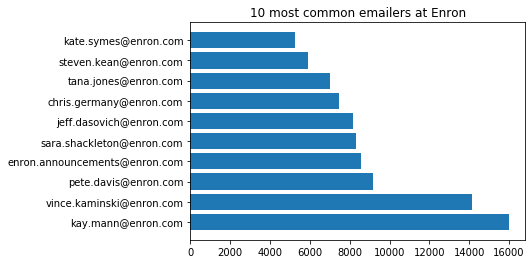

In [471]:
sender_counts = df['sender'].value_counts()
plt.barh(sender_counts.index[:10], sender_counts[:10])
plt.title('10 most common emailers at Enron')

Kay Mann and Vince Kaminski were the most frequent emailers at Enron by at least 4,000 emails, interesting.

In [474]:
df['folder'].value_counts()[:15]

all_documents         103382
sent                   53752
discussion_threads     45150
deleted_items          36911
sent_items             35567
inbox                  29140
_sent_mail             28341
notes_inbox            26064
calendar                3031
_americas               2928
archiving               2792
personal                1962
c                       1419
schedule_crawler        1398
attachments             1287
Name: folder, dtype: int64

The counts for emails in each folder confirms my earlier suspicion that there are some common folders.

In [476]:
after_nov = df['date'] > pd.to_datetime('2001-11-01')
before_2002 = df['date'] < pd.to_datetime('2001-12-30')

df.date.value_counts()[:15]

2000-12-13    2410
2000-12-12    2299
2002-01-30    2056
2001-11-27    2012
2000-12-11    1886
2001-10-25    1881
2001-11-26    1877
2000-12-04    1852
2001-11-19    1828
2001-05-01    1785
2001-11-20    1751
2001-10-26    1748
2001-10-24    1745
2001-04-25    1698
2001-10-23    1694
Name: date, dtype: int64

As Enron collapsed in late November 2001, I was curious if there was a high amount of emails sent around this time. 27th and 26th November feature in the top 10 for emails sent in a day but this does not suggest too much about their collapse.

Let us find out the most common n-address interactions. An interaction is defined as an email sent between the same n addresses. Most emails are sent from one person to another, so n is normally 2.

In [485]:
def get_interactions(senders, recipients):
    interactions = {}
    for sender, recipient in zip(senders, recipients):
        if sender != recipient:
            if (sender, recipient) and (recipient, sender) not in interactions:
                interactions[(sender, recipient)] = 1
            elif (sender, recipient) not in interactions:
                interactions[(recipient, sender)] += 1
            else:
                interactions[(sender, recipient)] += 1 
    return interactions
    
interact_dict = get_interactions(df['sender'], df['recipient'])

In [486]:
from collections import Counter

c = Counter(interact_dict).most_common(10)
combos = []
counts = []
for combo, count in c:
    combos.append(str(combo))
    counts.append(count)

Text(0.5, 0, 'Number of interactions')

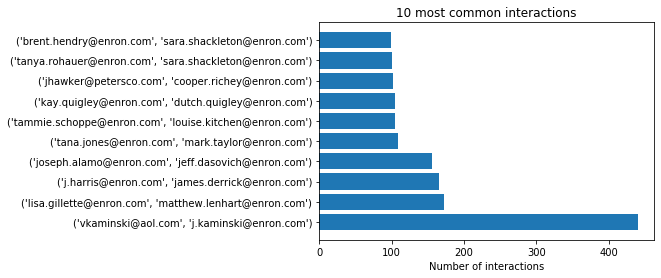

In [487]:
plt.barh(combos, counts)
plt.title('10 most common interactions')
plt.xlabel('Number of interactions')

It looks like V and J Kaminski discussed all their marriage problems through emails.

Let us define a group email as any email with multiple recipients. We can be confident that there will be an '@' for each recipient. Therefore, more than one '@' in the recipient string means the entry is a group email.

In [493]:
group_email = ['group' if recipient.count('@') > 1 else 'direct' for recipient in df['recipient']]
df['group email'] = group_email

In [498]:
group_email_counts = df.sender[df['group email']=='group'].value_counts()

group_email_counts[:15]

kay.mann@enron.com           2314
chris.germany@enron.com      1842
tana.jones@enron.com         1219
sara.shackleton@enron.com    1051
jeff.dasovich@enron.com      1016
david.delainey@enron.com      572
steven.kean@enron.com         541
carol.clair@enron.com         499
drew.fossum@enron.com         469
gerald.nemec@enron.com        429
d..steffes@enron.com          424
vince.kaminski@enron.com      410
sally.beck@enron.com          385
susan.scott@enron.com         367
kate.symes@enron.com          316
Name: sender, dtype: int64

In [499]:
print('It looks like {0} enjoyed a group email!'.format(group_email_counts.index[0]))

It looks like kay.mann@enron.com enjoyed a group email!


## Part 3: Machine Learning

Now I will attempt to fit a K-means model.

### Cleaning email content for training

I will use a bag-of-words approach to parsing the email content.

In [500]:
# Cleaning tools
import re
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Training tools
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import PCA

The following function `clean` does 5 cleaning operations:
* `rstrip` - removing trailing characters at the start and end of emails. These will clutter the vocabulary and be misleading to the K-means model.
* `re.sub` - removes parts of the content string which are not words.
* `stop` - a set of the stop words we will remove so that more focus can be given to meaningful words.
* `exclude` - a set of the punctuation that will be removed.
* `lemma` - a lemmatiser which will reduce the vocabulary and allow us to consider words such as 'run' and 'running' to have the same meaning.

In [501]:
def clean(text, stop):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    
    text = text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = ' '.join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    lemmatized = ' '.join(lemma.lemmatize(word) for word in punc_free.split())
    
    return lemmatized
    

In [511]:
df_sample = df.sample(5000)

stop = set(stopwords.words('english'))
df_sample['clean text'] = [clean(text, stop) for text in df_sample['content']]

Tfidf is a better measure of word importance in a document set than simple word frequency counts. The inverse document frequency expression in tfidf's calculation  

In [512]:
tfidf = TfidfVectorizer(stop_words=stop)
tfidf_vec = tfidf.fit_transform(df_sample['clean text'])


In [513]:
vocab = tfidf.get_feature_names()

In [514]:
N=3
kmeans = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = kmeans.fit_predict(tfidf_vec)

To visualise the clustering, we need to reduce the dimensionality of the data to 2. We can do this with Principle Component Analysis (PCA).

In [515]:
tfidf_vec_2d = tfidf_vec.todense()
pca = PCA(n_components=2).fit(tfidf_vec_2d)
datapoint = pca.transform(tfidf_vec_2d)

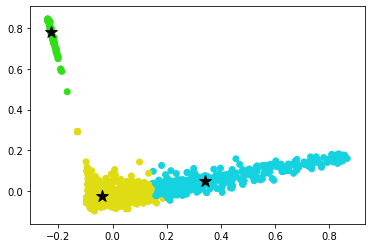

In [516]:
label = ["#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='*', s=150, c='#000000')
plt.show()

Unfortunately I didn't have time to conduct analysis on this K-Means model.